<br>

**Herein**, a varying intercept & varying gradient stochastic regression model wherein the dependent variables are modelled as covarying series.

<br>

# Preliminaries

Cleaning-up

In [1]:
!rm -rf *.sh

<br>

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/sars/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Paths**

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)


In [6]:
warehouse = 'capita'

if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

**Libraries**

In [7]:
%matplotlib inline

In [8]:
import arviz as az
import graphviz
import pymc3 as pm

import logging
import collections

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano


<br>

Custom

In [9]:
import sars.graphics.settings
import sars.graphics.relational

<br>

**Generic Instances**

In [10]:
relational = sars.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

## Set-up

**Display**<br>
If the display screen supports **retina display**, a figure's resolution can be enhanced via


In [11]:
%config InlineBackend.figure_format = 'retina'

<br>

**Jupyter Settings**

In [12]:
settings = sars.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

## Logging

In [13]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Baseline

In [14]:
import sars.models.inpatients.src.baseline

In [15]:
baseline = sars.models.inpatients.src.baseline.Baseline().exc()

In [16]:
logger.info('\n{}\n'.format(baseline.tail()))

INFO:__main__:
      datetimeobject STUSPS  deathCumulative  positiveCumulative  \
11983     2020-12-06     WY            257.0             36317.0   
11984     2020-12-07     WY            280.0             36985.0   
11985     2020-12-08     WY            280.0             37475.0   
11986     2020-12-09     WY            299.0             37885.0   
11987     2020-12-10     WY            299.0             38223.0   

       hospitalizedCumulative  deathRate  positiveRate  hospitalizedRate  \
11983                   852.0  44.405357   6274.978013        147.211534   
11984                   901.0  48.379377   6390.397385        155.677925   
11985                   911.0  48.379377   6475.061295        157.405760   
11986                   920.0  51.662264   6545.902526        158.960811   
11987                   929.0  51.662264   6604.303346        160.515862   

       ndays  
11983    319  
11984    320  
11985    321  
11986    322  
11987    323  



<br>
<br>

## Focus

In [17]:
Futures = collections.namedtuple(typename='Futures', field_names=['steps', 'ahead'])
futures = Futures._make([np.array([1]), 21])

In [18]:
Variables = collections.namedtuple(typename='Variables', field_names=['independent', 'dependent', 'label'])
variables = Variables._make((['ndays'], ['positiveRate', 'hospitalizedRate', 'deathRate'], 
                             ['positive/100K [C]', 'hospitalized/100K [C]', 'death/100K [C]']))

<br>

**State**

In [19]:
stusps = 'ND'

<br>

**Data**

* N: The number of records
* M: The number of independent variables
* P: The number of dependent variables

In [20]:
import sars.models.inpatients.src.focus

In [21]:
data, parameters = sars.models.inpatients.src.focus.Focus(
    baseline=baseline, variables=variables, futures=futures).exc(stusps=stusps)

logger.info('The fields of data\n{}\n'.format(data._fields))
logger.info('The fields of parameters\n{}\n'.format(parameters._fields))

INFO:sars.models.inpatients.src.focus:
     positiveRate  hospitalizedRate   deathRate
260  11115.499789        377.922006  133.716154
261  11166.283058        380.021573  134.897161
262  11242.654797        380.021573  134.897161
263  11304.723238        391.569190  142.508090
264  11377.945626        391.569190  145.526217

INFO:__main__:The fields of data
('abscissae', 'independent', 'dependent')

INFO:__main__:The fields of parameters
('N', 'M', 'P')



<br>

**Illustration**

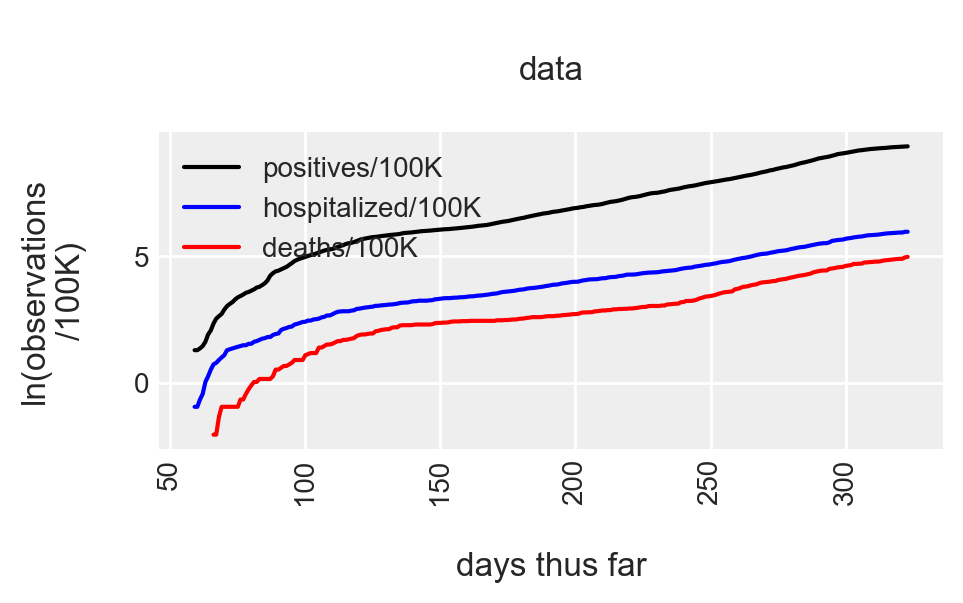

In [22]:
ax = relational.figure(width=4.7, height=2.9)
ax.set_prop_cycle(color=['black', 'blue', 'red'])

ax.plot(data.independent, np.log(data.dependent), '-')

ax.tick_params(axis='x', labelrotation=90)
relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata\n', '\ndays thus far', 'ln(observations\n/100K)\n']))

ax.legend(labels=['positives/100K', 'hospitalized/100K', 'deaths/100K'], loc='upper left', fontsize='small');                      

<br>
<br>

# Inference

## Scaled Tensors

In [23]:
import sars.models.inpatients.scaled

In [24]:
scaled = sars.models.inpatients.scaled.Scaled(data=data).exc()

logger.info('scaled\n{}\n'.format(scaled._fields))

INFO:__main__:scaled
('xscale', 'independent', 'abscissae', 'yscale', 'dependent')



<br>

## Elements

In [25]:
import sars.models.inpatients.elements

In [26]:
sections_ = scaled.independent.shape[0]
instances_ = np.ones(shape=scaled.independent.shape[0], dtype=int)

elements = sars.models.inpatients.elements.Elements(sections_=sections_, instances_=instances_).exc()

logger.info('elements\n{}\n'.format(elements._fields))

INFO:__main__:elements
('sections_', 'instances_', 'indices')



<br>
<br>

## Model

<br>

**Inference**

In [27]:
import sars.models.inpatients.capita.inference

In [28]:
inference = sars.models.inpatients.capita.inference.Inference(data=scaled, parameters=parameters, elements=elements)

<br>

Inference Model Characteristics

In [29]:
imc = inference.exc()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]
INFO:pymc3:NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4195 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4195 seconds.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 519 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 519 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number


INFO:pymc3:


In [30]:
imc._fields

('model', 'trace', 'maximal', 'arviztrace', 'likelihood')

<br>

**DAG**

* http://www.graphviz.org/doc/info/attrs.html

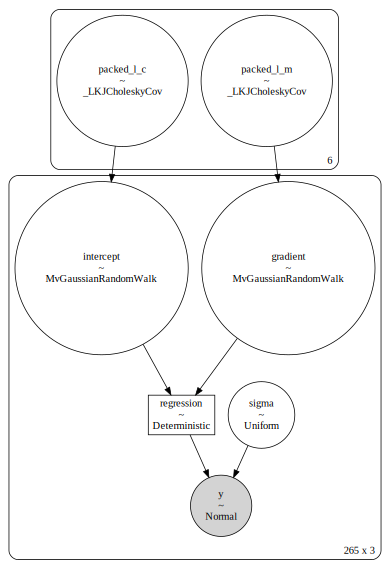

In [31]:
# The DAG
diagram = pm.model_graph.ModelGraph(model=imc.model).make_graph()
diagram.node_attr.update(shape='circle')
diagram.graph_attr.update(size="5.7,7.9")

# Diagrams
diagram.save(os.path.join(warehouse, 'model.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(warehouse, 'model.gv'))

graphviz.Source.from_file(filename=os.path.join(warehouse, 'model.gv'))

<br>

**Trace**

In [32]:
imc.trace.varnames

['packed_l_c_cholesky-cov-packed__',
 'intercept',
 'packed_l_m_cholesky-cov-packed__',
 'gradient',
 'sigma_interval__',
 'packed_l_c',
 'packed_l_m',
 'regression',
 'sigma']

<br>

Samplings

In [33]:
samplings = imc.trace.report.n_draws * imc.trace.nchains
logger.info('The number of sampled instances\n{}\n'.format(samplings))

INFO:__main__:The number of sampled instances
2000



<br>
<br>

# Analysis

## Estimates

In [34]:
import sars.models.inpatients.estimates

In [35]:
estimates = sars.models.inpatients.estimates.Estimates(
    trace=imc.trace, futures=futures, samplings=samplings, parameters=parameters)

<br>

**Intercepts & Gradients**

In [36]:
Arguments = collections.namedtuple(typename='Arguments', field_names=['name', 'cholesky'])

intercepts = estimates.exc(arguments=Arguments._make(('intercept', 'packed_l_c')))
gradients = estimates.exc(arguments=Arguments._make(('gradient', 'packed_l_m')))

logger.info('\n{}\n'.format(intercepts.shape))
logger.info('\n{}\n'.format(gradients.shape))

INFO:__main__:
(2000, 286, 3)

INFO:__main__:
(2000, 286, 3)



<br>
<br>

## Predictions

In [37]:
import sars.models.inpatients.predictions

In [38]:
predictions = sars.models.inpatients.predictions.Predictions(
    intercepts=intercepts, gradients=gradients, samplings=samplings, scaled=scaled, parameters=parameters).exc(size=100)

In [39]:
logger.info('\n{}\n'.format(predictions._fields))

INFO:__main__:
('line', 'lines')



In [40]:
logger.info('\n{}\n'.format(predictions.line.shape))
logger.info('\n{}\n'.format(predictions.lines.shape))

INFO:__main__:
(286, 3)

INFO:__main__:
(100, 286, 3)



<br>
<br>

# Illustrate

In [41]:
import sars.models.inpatients.graphs

In [42]:
graphs = sars.models.inpatients.graphs.Graphs(data=data, predictions=predictions, titles=variables.label)

<br>

**Together**

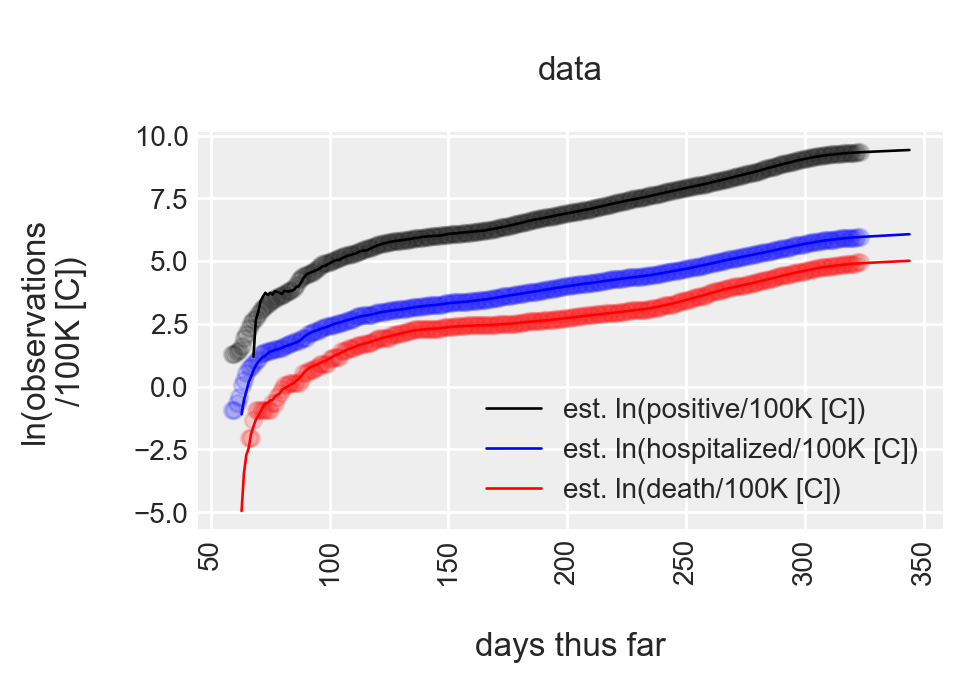

In [43]:
graphs.together(ylabel='ln(observations\n/100K [C])')

<br>

**Separate**

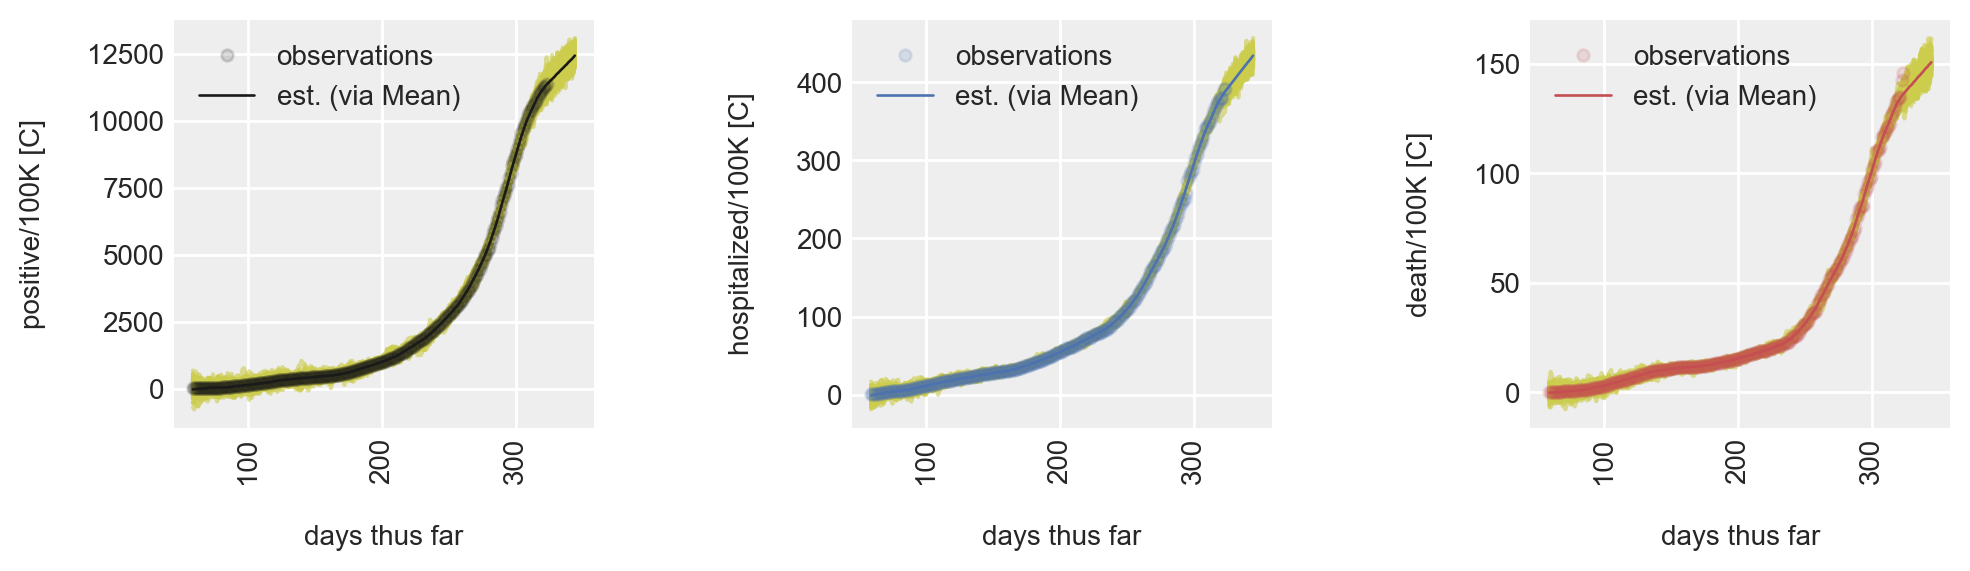

In [44]:
fig, handle = graphs.separate(adjust=np.array([None, None]), layout=np.array([None, 5]))

In [45]:
fig.savefig(os.path.join(warehouse, 'capita.png'), bbox_inches='tight', pad_inches=0.2)